# Facebook Prophet vs NYC Shelter Demand 

In [1]:
!conda activate stan_env

# Import Libraries

In [2]:
#import libraries
import itertools
import prophet as Prophet 
import pandas as pd 
import numpy as np

Importing plotly failed. Interactive plots will not work.


In [21]:
#reading dataset
data = pd.read_csv(r'C:\Users\priyashukla\Downloads\Forecasting Models and Time Series for Business in Python\7. Facebook Prophet\DHS_Daily_Report_2020.csv')
data.head(1)

,Date,Total Adults in Shelter,Total Children in Shelter,Total Individuals in Shelter,Single Adult Men in Shelter,Single Adult Women in Shelter,Total Single Adults in Shelter,Families with Children in Shelter,Adults in Families with Children in Shelter,Children in Families with Children in Shelter,Total Individuals in Families with Children in Shelter,Adult Families in Shelter,Easter,Thanksgiving,Christmas
0,1/1/2014,28770,21919,50689,7269,2650,9919,10469,14897,21919,1866,3954,0,0,0


# Data Transformation

In [22]:
#renaming columns - date, dependent variable
data = data.rename(columns={"Date":"ds", 
                            "Total Individuals in Shelter": "y"})
data.head(1)

,ds,Total Adults in Shelter,Total Children in Shelter,y,Single Adult Men in Shelter,Single Adult Women in Shelter,Total Single Adults in Shelter,Families with Children in Shelter,Adults in Families with Children in Shelter,Children in Families with Children in Shelter,Total Individuals in Families with Children in Shelter,Adult Families in Shelter,Easter,Thanksgiving,Christmas
0,1/1/2014,28770,21919,50689,7269,2650,9919,10469,14897,21919,1866,3954,0,0,0


In [23]:
#date variable
data.ds = pd.to_datetime(data.ds, 
                            format = "%m/%d/%Y")
data.ds

0      2014-01-01
1      2014-01-02
2      2014-01-03
3      2014-01-04
4      2014-01-05
          ...    
2552   2020-12-27
2553   2020-12-28
2554   2020-12-29
2555   2020-12-30
2556   2020-12-31
Name: ds, Length: 2557, dtype: datetime64[ns]

In [24]:
#final dataset 
dataset = data[["ds","y","Easter", "Thanksgiving", "Christmas"]]
dataset.tail(1)

,ds,y,Easter,Thanksgiving,Christmas
2556,2020-12-31,52874,4210,0,0



        
# Holidays

In [25]:
#easter
holiday_dates_easter = dataset[dataset.Easter==1].ds
holidays_easter = pd.DataFrame({'holiday' : 'Easter',
                        'ds': pd.to_datetime(holiday_dates_easter),
                        'lower_window': -3,
                        'upper_window': 1})
holidays_easter.head()

,holiday,ds,lower_window,upper_window
109,Easter,2014-04-20,-3,1
459,Easter,2015-04-05,-3,1
816,Easter,2016-03-27,-3,1
1201,Easter,2017-04-16,-3,1
1551,Easter,2018-04-01,-3,1


In [26]:
#thanksgiving 
holiday_dates_tg = dataset[dataset.Thanksgiving==1].ds
holidays_tg = pd.DataFrame({'holiday' : 'Thanksgiving',
                        'ds': pd.to_datetime(holiday_dates_tg),
                        'lower_window': -3,
                        'upper_window': 1})
holidays_tg.head()

,holiday,ds,lower_window,upper_window
330,Thanksgiving,2014-11-27,-3,1
694,Thanksgiving,2015-11-26,-3,1
1058,Thanksgiving,2016-11-24,-3,1
1422,Thanksgiving,2017-11-23,-3,1
1786,Thanksgiving,2018-11-22,-3,1


In [27]:
#concat holidays
holidays = pd.concat([holidays_easter,holidays_tg])
holidays.tail()

,holiday,ds,lower_window,upper_window
1058,Thanksgiving,2016-11-24,-3,1
1422,Thanksgiving,2017-11-23,-3,1
1786,Thanksgiving,2018-11-22,-3,1
2157,Thanksgiving,2019-11-28,-3,1
2521,Thanksgiving,2020-11-26,-3,1


In [28]:
#removing holiday columns
dataset = dataset.drop(columns = ['Thanksgiving', 'Easter'])
dataset.head(1)

,ds,y,Christmas
0,2014-01-01,50689,0


# Training and Test dataset

In [29]:
#Training and test dataset
test_days = 31
training_set = dataset.iloc[:-test_days,:]
test_set = dataset.iloc[-test_days:, :]
test_set.tail(1)

,ds,y,Christmas
2556,2020-12-31,52874,0


# Facebook Prophet

In [30]:
#Facebook Prophet model 
m = Prophet.Prophet(growth = "linear",
           yearly_seasonality = True,
           weekly_seasonality = True,
           daily_seasonality = False,
           holidays = holidays,
           seasonality_mode = "multiplicative",
           seasonality_prior_scale = 10,
           holidays_prior_scale = 10,
           changepoint_prior_scale = 0.05)
m.add_regressor('Christmas')
m.fit(training_set)

12:52:55 - cmdstanpy - INFO - Chain [1] start processing
12:52:56 - cmdstanpy - INFO - Chain [1] done processing


# Model Assessment

In [34]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_prophet),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_prophet)),0))

NameError: name 'predictions_prophet' is not defined

In [ ]:
#MAPE function
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_prophet)

# Forecasting

In [35]:
#create future dataframe 
future = m.make_future_dataframe(periods = len(test_set),
                                 freq = "D")
future.tail(1)

,ds
2556,2020-12-31


In [36]:
#merge regressors
future = pd.concat([future, dataset.iloc[:,1:]],
                  axis = 1)
future.tail()

,ds,y,Christmas
2552,2020-12-27,53534,0
2553,2020-12-28,53349,0
2554,2020-12-29,53206,0
2555,2020-12-30,53085,0
2556,2020-12-31,52874,0


In [37]:
future = future.drop(columns = {'y'})
future.head(1)

,ds,Christmas
0,2014-01-01,0


In [38]:
#Forecast
forecast = m.predict(future)
forecast.head(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,Easter,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2014-01-01,50093.39041,50471.801327,51238.425867,50093.39041,50093.39041,0.0,0.0,0.0,0.0,...,0.000658,0.000658,0.000658,0.014376,0.014376,0.014376,0.0,0.0,0.0,50846.47009


In [39]:
#Predictions 
predictions_prophet = forecast.yhat[-test_days:].rename("prophet")
predictions_prophet[:5]

2526    54965.506464
2527    55005.292156
2528    55015.772081
2529    54949.075529
2530    54918.242896
Name: prophet, dtype: float64

# Visualization

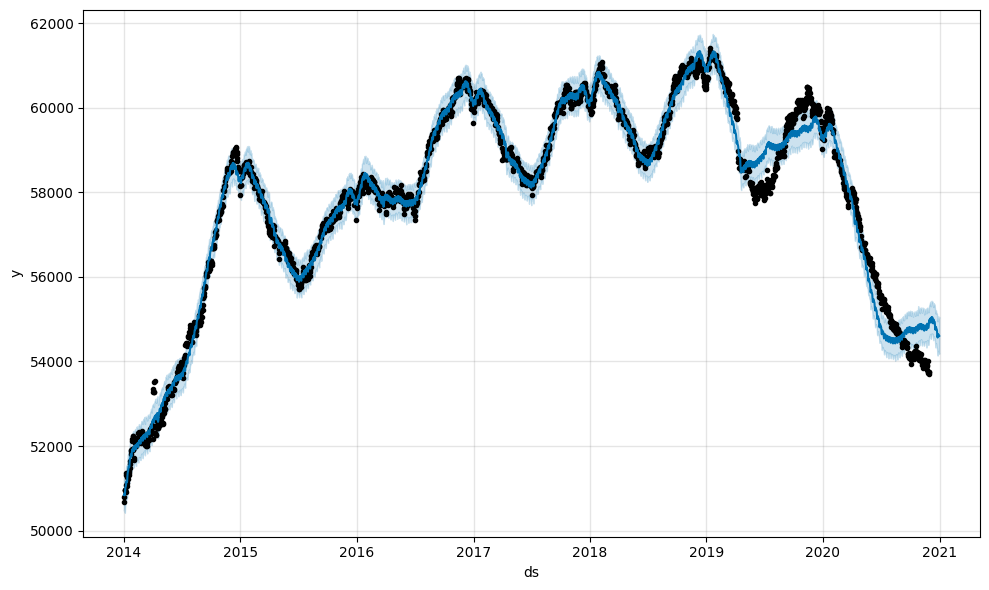

In [42]:
#visualization
m.plot(forecast);

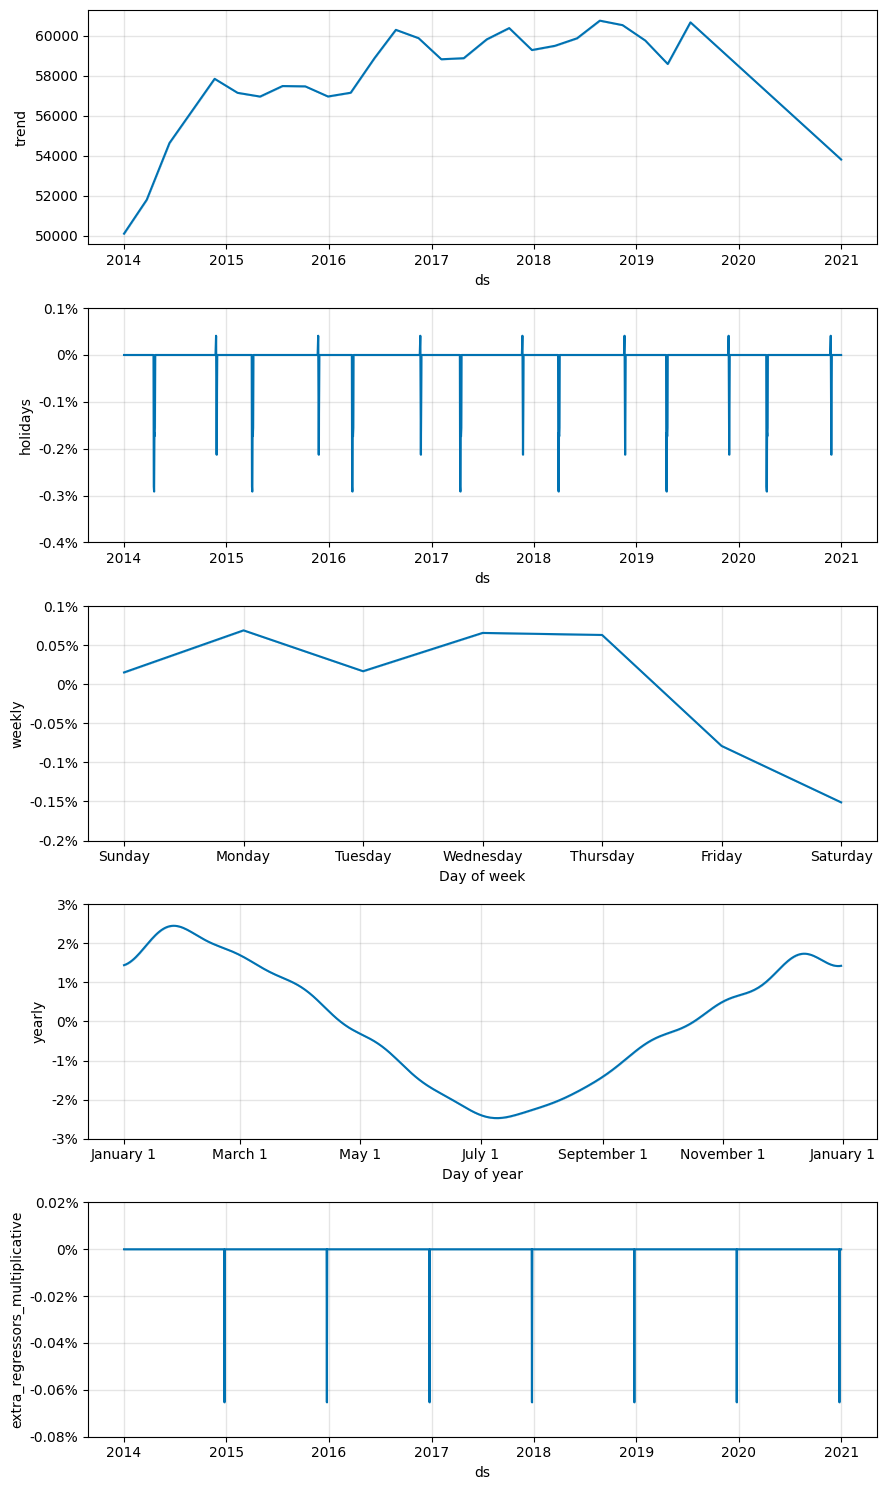

In [43]:
#plot components
m.plot_components(forecast);

# Model Assessment

In [44]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_prophet),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_prophet)),0))

1306.0
1313.0


In [45]:
#MAPE function
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_prophet)

2.439777746143265

## Cross Validation

In [46]:
#CV
from prophet.diagnostics import cross_validation 
df_cv = cross_validation(m, 
                        horizon = '31 days',
                        initial = '2400 days',
                        parallel = "processes")
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-30,56151.142582,55898.397567,56404.109533,55090,2020-07-29
1,2020-07-31,56090.290009,55833.773701,56344.735613,54930,2020-07-29
2,2020-08-01,56072.458423,55815.452289,56326.581176,54810,2020-07-29
3,2020-08-02,56193.187231,55908.153671,56461.882309,54956,2020-07-29
4,2020-08-03,56249.652540,55980.889433,56526.233051,54978,2020-07-29


In [48]:
#MAE and RMSE
print("MAE:",round(mean_absolute_error(df_cv['y'], df_cv['yhat']),0))
print("RMSE:",round(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])),0))
print("MAPE:",MAPE(df_cv['y'], df_cv['yhat']))

MAE: 1990.0
RMSE: 2022.0
MAPE: 3.6665965509448415


# Parameter Grid

In [49]:
#parameter grid
from sklearn.model_selection import ParameterGrid
param_grid = {'seasonality_prior_scale':[5, 10, 20],
             'holidays_prior_scale':[5, 10, 20],
             'changepoint_prior_scale':[0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
list(grid)[:3]

[{'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 20}]

# Hyperparameter Tuning

In [50]:
rsme = [] 
for params in grid:
    #build model 
    m = Prophet.Prophet(growth = "linear",
           yearly_seasonality = True,
           weekly_seasonality = True,
           daily_seasonality = False,
           holidays = holidays,
           seasonality_mode = "multiplicative",
           seasonality_prior_scale = 10,
           holidays_prior_scale = 10,
           changepoint_prior_scale = 0.05)
    m.add_regressor('Christmas')
    m.fit(training_set)
    
    #cross-validation
    df_cv = cross_validation(m, 
                        horizon = '31 days',
                        initial = '2400 days',
                        parallel = "processes")
    
    #gather results
    error = np.sqrt(mean_squared_error(df_cv['y'], 
                                       df_cv['yhat']))
    rsme.append(error)

17:15:52 - cmdstanpy - INFO - Chain [1] start processing
17:15:54 - cmdstanpy - INFO - Chain [1] done processing
17:16:25 - cmdstanpy - INFO - Chain [1] start processing
17:16:27 - cmdstanpy - INFO - Chain [1] done processing
17:16:59 - cmdstanpy - INFO - Chain [1] start processing
17:17:01 - cmdstanpy - INFO - Chain [1] done processing
17:17:31 - cmdstanpy - INFO - Chain [1] start processing
17:17:34 - cmdstanpy - INFO - Chain [1] done processing
17:18:05 - cmdstanpy - INFO - Chain [1] start processing
17:18:08 - cmdstanpy - INFO - Chain [1] done processing
17:18:40 - cmdstanpy - INFO - Chain [1] start processing
17:18:43 - cmdstanpy - INFO - Chain [1] done processing
17:19:20 - cmdstanpy - INFO - Chain [1] start processing
17:19:23 - cmdstanpy - INFO - Chain [1] done processing
17:19:59 - cmdstanpy - INFO - Chain [1] start processing
17:20:01 - cmdstanpy - INFO - Chain [1] done processing
17:20:44 - cmdstanpy - INFO - Chain [1] start processing
17:20:47 - cmdstanpy - INFO - Chain [1]

In [51]:
#best parameters
best_params = grid[np.argmin(rsme)]
print(best_params)

{'seasonality_prior_scale': 5, 'holidays_prior_scale': 5, 'changepoint_prior_scale': 0.01}


# Final Model

In [52]:
#final model 
m = Prophet.Prophet(growth = "linear",
       yearly_seasonality = True,
       weekly_seasonality = True,
       daily_seasonality = False,
       holidays = holidays,
       seasonality_mode = "multiplicative",
       seasonality_prior_scale = 5,
       holidays_prior_scale = 5,
       changepoint_prior_scale = 0.01)
m.add_regressor('Christmas')
m.fit(training_set)

17:37:36 - cmdstanpy - INFO - Chain [1] start processing
17:37:39 - cmdstanpy - INFO - Chain [1] done processing


In [53]:
#create future dataframe
future = m.make_future_dataframe(periods = len(test_set),
                                freq = "D")
future.tail(1)

,ds
2556,2020-12-31


In [54]:
#merge regressors 
future = pd.concat([future, dataset.iloc[:,2:]],
                  axis = 1)
future.tail()

,ds,Christmas
2552,2020-12-27,0
2553,2020-12-28,0
2554,2020-12-29,0
2555,2020-12-30,0
2556,2020-12-31,0


In [55]:
# Forecast
forecast = m.predict(future)
forecast.head(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,Easter,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2014-01-01,50145.163255,50391.862015,51323.35719,50145.163255,50145.163255,0.0,0.0,0.0,0.0,...,0.000652,0.000652,0.000652,0.013374,0.013374,0.013374,0.0,0.0,0.0,50848.518592


In [56]:
#predictions 
predictions_prophet_tuned = forecast.yhat[-test_days:].rename("prophet_tuned")
predictions_prophet_tuned.index = test_set["ds"]
predictions_prophet_tuned[:5]

ds
2020-12-01    55111.128135
2020-12-02    55146.410141
2020-12-03    55153.039353
2020-12-04    55081.705522
2020-12-05    55046.013153
Name: prophet_tuned, dtype: float64

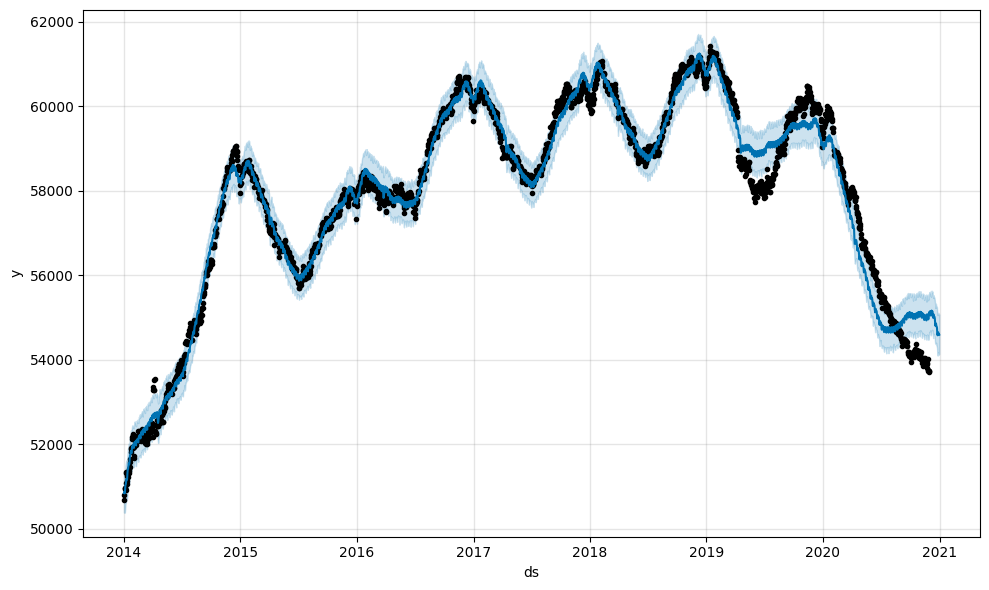

In [57]:
#visualization
m.plot(forecast);

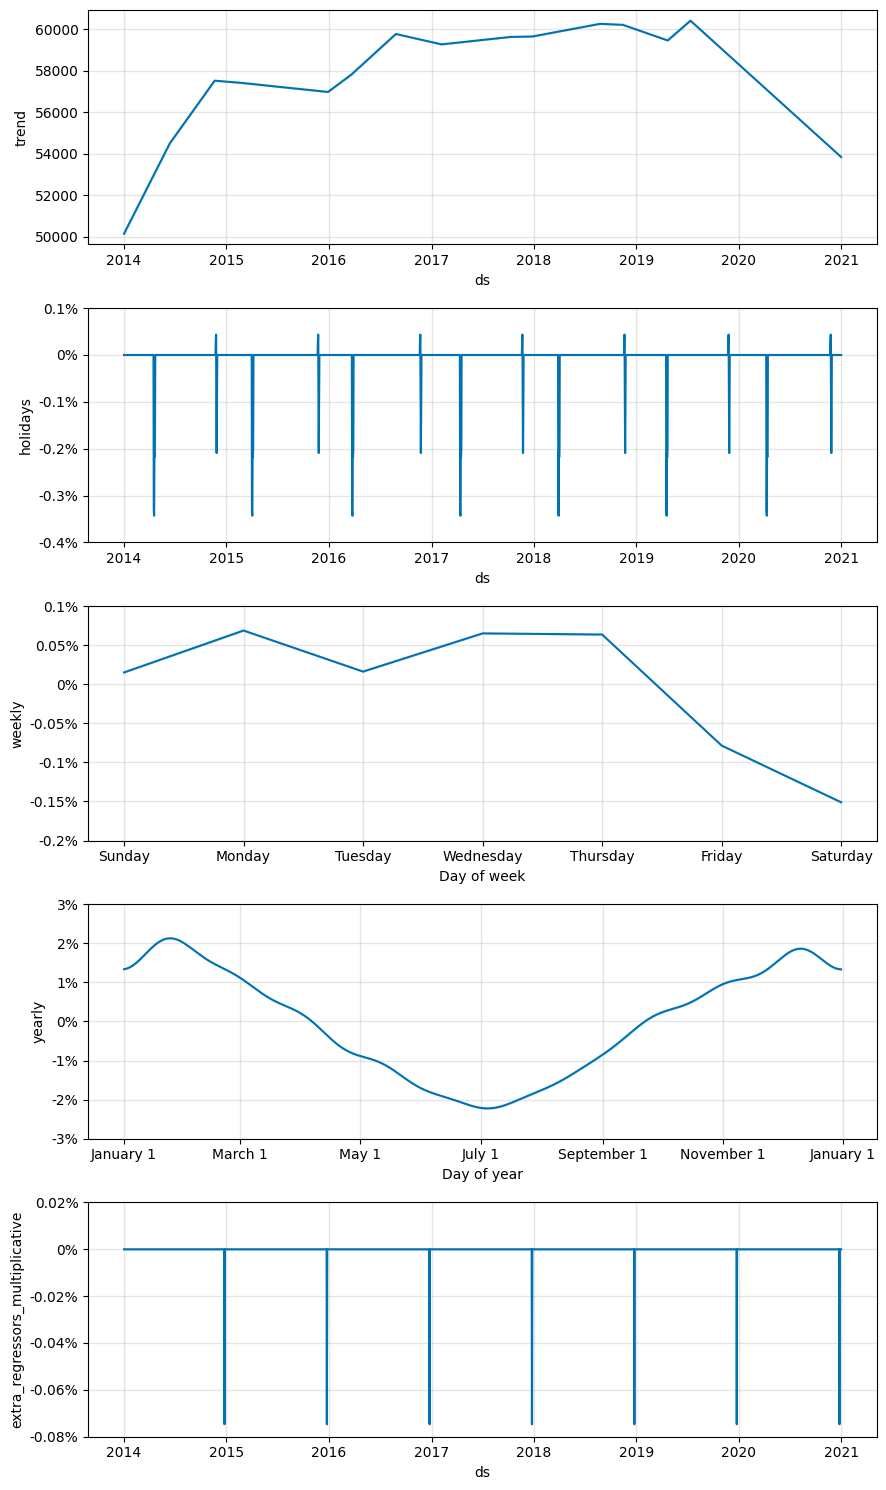

In [58]:
#plot components
m.plot_components(forecast);